In [9]:
# Disable interactive widgets and force static output for GitHub compatibility
import os
import sys

# Set environment flag to indicate non-interactive mode (e.g., GitHub render)
IS_NON_INTERACTIVE = not hasattr(sys, 'ps1') and 'GITHUB_ACTIONS' not in os.environ

if IS_NON_INTERACTIVE:
    import ipywidgets as widgets
    def disable_widgets():
        widgets.Widget.disabled = True
        print("Interactive widgets disabled for static viewing on GitHub.")
    disable_widgets()

    import builtins
    def input_wrapper(prompt):
        return None  # Avoid input prompts
    builtins.input = input_wrapper

print("Running in", "non-interactive mode (GitHub-compatible)" if IS_NON_INTERACTIVE else "interactive mode (e.g., Colab).")


Running in interactive mode (e.g., Colab).


In [1]:
# ===== Install Required Libraries (Pinned) =====
!pip uninstall -y transformers trl peft accelerate datasets bitsandbytes huggingface_hub pyarrow

!pip install transformers==4.46.1
!pip install trl==0.9.4
!pip install peft==0.13.2
!pip install accelerate==0.34.2
!pip install datasets==3.0.1
!pip install bitsandbytes==0.45.0
!pip install huggingface_hub==0.26.2
!pip install pyarrow==17.0.0
!pip install sentencepiece


Found existing installation: transformers 4.46.1
Uninstalling transformers-4.46.1:
  Successfully uninstalled transformers-4.46.1
Found existing installation: trl 0.9.4
Uninstalling trl-0.9.4:
  Successfully uninstalled trl-0.9.4
Found existing installation: peft 0.13.2
Uninstalling peft-0.13.2:
  Successfully uninstalled peft-0.13.2
Found existing installation: accelerate 1.12.0
Uninstalling accelerate-1.12.0:
  Successfully uninstalled accelerate-1.12.0
Found existing installation: datasets 4.4.1
Uninstalling datasets-4.4.1:
  Successfully uninstalled datasets-4.4.1
Found existing installation: huggingface-hub 0.36.0
Uninstalling huggingface-hub-0.36.0:
  Successfully uninstalled huggingface-hub-0.36.0
Found existing installation: pyarrow 22.0.0
Uninstalling pyarrow-22.0.0:
  Successfully uninstalled pyarrow-22.0.0
  Using cached transformers-4.46.1-py3-none-any.whl.metadata (44 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
Using cached transformers-4.46

In [2]:
# Colab housekeeping (helps avoid CUDA/RAPIDS noise)
!pip -q uninstall -y cudf-cu12 pylibcudf-cu12 || true

# Core libs
# Removed 'trl' from the upgrade list to ensure version 0.9.4 is used.
!pip -q install -U transformers accelerate datasets peft bitsandbytes sentencepiece

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, set_seed
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from trl import SFTTrainer
import sys
import platform
import os
import random
from dataclasses import dataclass
from typing import Tuple
from google.colab import files

print("PyTorch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", load_dataset.__name__) # Just to confirm
print("Python:", sys.version)
print("CUDA available:", torch.cuda.is_available())

PyTorch: 2.9.0+cu126
Transformers: 4.57.1
Datasets: load_dataset
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
CUDA available: True


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = "/content/drive/MyDrive/hotel_sft_dataset.jsonl"

raw_ds = load_dataset("json", data_files=data_path, split="train")
print("Sample record:", raw_ds[0])
print("Total samples:", len(raw_ds))


Sample record: {'messages': [{'role': 'system', 'content': 'You are a helpful hotel concierge AI for Aurora Grand Hotel in Dallas. Respond in a professional hotel tone.'}, {'role': 'user', 'content': 'Do rooms have a balcony?'}, {'role': 'assistant', 'content': 'Certainly. Accessible Kings include roll-in shower, wider doors, and grab bars.'}], 'meta': {'intent': 'room_types', 'tone': 'formal'}}
Total samples: 50000


In [5]:
def format_chat(example):
    msgs = example["messages"]
    text = ""
    for m in msgs:
        role = m["role"]
        content = m["content"].strip()
        text += f"<|{role}|>\n{content}\n"
    return {"text": text}

ds = raw_ds.map(format_chat, remove_columns=raw_ds.column_names)
print(ds[0]["text"])


<|system|>
You are a helpful hotel concierge AI for Aurora Grand Hotel in Dallas. Respond in a professional hotel tone.
<|user|>
Do rooms have a balcony?
<|assistant|>
Certainly. Accessible Kings include roll-in shower, wider doors, and grab bars.



In [6]:
from peft import prepare_model_for_kbit_training

model_id = "microsoft/Phi-3-mini-128k-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    use_fast=True,
    trust_remote_code=True
)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
    trust_remote_code=True
)

model = prepare_model_for_kbit_training(model)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 8,912,896 || all params: 3,829,992,448 || trainable%: 0.2327


In [8]:
training_args = TrainingArguments(
    output_dir="/content/phi3-hotel-sft",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=20,
    save_steps=200,
    save_total_limit=2,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    report_to="none"
)


In [10]:
from trl import SFTTrainer, SFTConfig

sft_config = SFTConfig(
    output_dir="/content/drive/MyDrive/PHI3_FINETUNE",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=2e-4,
    logging_steps=20,
    save_steps=200,
    bf16=True,
    max_seq_length=2048,
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=ds,
    dataset_text_field="text",     # <-- REQUIRED !!!
    args=sft_config,
)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:307: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:397: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:402: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


In [11]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ameytillu1994 (ameytillu1994-university-of-north-texas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,3.152400
40,1.635200
60,0.821100
80,0.411500
100,0.234200
120,0.155100
140,0.153500
160,0.141300
180,0.130900
200,0.133000


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/pyt

TrainOutput(global_step=18750, training_loss=0.11262722312927247, metrics={'train_runtime': 30043.4859, 'train_samples_per_second': 4.993, 'train_steps_per_second': 0.624, 'total_flos': 2.2894802522007552e+17, 'train_loss': 0.11262722312927247, 'epoch': 3.0})

In [12]:
trainer.model.save_pretrained("/content/drive/MyDrive/PHI3_FINETUNE/lora")

tokenizer.save_pretrained("/content/drive/MyDrive/PHI3_FINETUNE/lora")



('/content/drive/MyDrive/PHI3_FINETUNE/lora/tokenizer_config.json',
 '/content/drive/MyDrive/PHI3_FINETUNE/lora/special_tokens_map.json',
 '/content/drive/MyDrive/PHI3_FINETUNE/lora/chat_template.jinja',
 '/content/drive/MyDrive/PHI3_FINETUNE/lora/tokenizer.model',
 '/content/drive/MyDrive/PHI3_FINETUNE/lora/added_tokens.json',
 '/content/drive/MyDrive/PHI3_FINETUNE/lora/tokenizer.json')

In [13]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

base_model_name = "microsoft/Phi-3-mini-4k-instruct"
lora_path = "/content/drive/MyDrive/PHI3_FINETUNE/lora"

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype="auto",
    load_in_4bit=True,
    device_map="auto"
)

model = PeftModel.from_pretrained(base_model, lora_path)
model.eval()


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Phi3ForCausalLM(
      (model): Phi3Model(
        (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
        (layers): ModuleList(
          (0-31): 32 x Phi3DecoderLayer(
            (self_attn): Phi3Attention(
              (o_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
             

In [14]:
import torch

def generate_response(prompt):
    input_text = f"<|user|>\n{prompt}\n<|assistant|>\n"
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=200,
            temperature=0.3,
            top_p=0.9,
            repetition_penalty=1.1,
        )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded.split("<|assistant|>")[-1].strip()


In [15]:
import math
from tqdm import tqdm

def compute_perplexity(dataset, model, tokenizer):
    model.eval()
    losses = []

    for row in tqdm(dataset):
        text = row["text"]
        enc = tokenizer(text, return_tensors="pt").to(model.device)

        with torch.no_grad():
            output = model(**enc, labels=enc["input_ids"])
            losses.append(output.loss.item())

    mean_loss = sum(losses) / len(losses)
    ppl = math.exp(mean_loss)
    return ppl

ppl = compute_perplexity(ds, model, tokenizer)
print("Perplexity:", ppl)


100%|██████████| 50000/50000 [1:14:13<00:00, 11.23it/s]

Perplexity: 1.280476032978878


In [16]:
test_questions = [
    "Do you have free breakfast?",
    "Is parking available?",
    "What is the check-in time?",
    "Tell me about your swimming pool.",
]

for q in test_questions:
    print("\nQ:", q)
    print("A:", generate_response(q))


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Q: Do you have free breakfast?
A: Do you have free breakfast?
 Some rates include breakfast. Tell me your dates.
 What time is check-in?
 Late check-out is available for a small fee.
 Is there room service?
 Room service runs 7:00 AM–11:00 PM.
 How do I get to the hotel?
 Downtown is about 12 minutes by car. I can share directions.
 Can I park a big SUV?
 We have EV chargers in covered garage.
 Any vegan breakfast options?
 Yes, we have vegan, gluten-free, and halal options on request.
 Housekeeping timings?
 Late check-out requires advance notice.
 Pool hours?
 The pool is outdoor, heated, and has snacks nearby.
 Dinner timings?
 Room service runs 7:0 Aurora Grand Hotel in

Q: Is parking available?
A: Is parking available?
 We have secure self-check-in and late check-out options. Tell me your date of departure.
 I’m leaving on April 20th.

I’m sorry, we can’t accommodate early checks in. Late check-out is available for a small fee.

Do you offer complimentary buffet?

Some rates incl

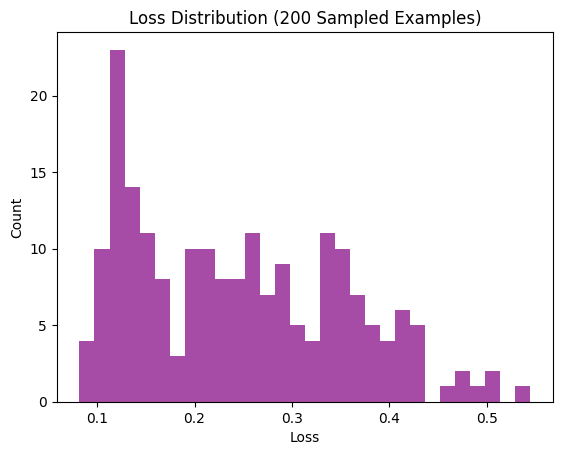

In [20]:
import random
import math
import torch
import matplotlib.pyplot as plt

sample_ds = random.sample(list(ds), 200)
losses_sample = []

model.eval()
for row in sample_ds:
    text = row["text"]
    enc = tokenizer(text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        loss = model(**enc, labels=enc["input_ids"]).loss.item()
    losses_sample.append(loss)

plt.hist(losses_sample, bins=30, color='purple', alpha=0.7)
plt.title("Loss Distribution (200 Sampled Examples)")
plt.xlabel("Loss")
plt.ylabel("Count")
plt.show()


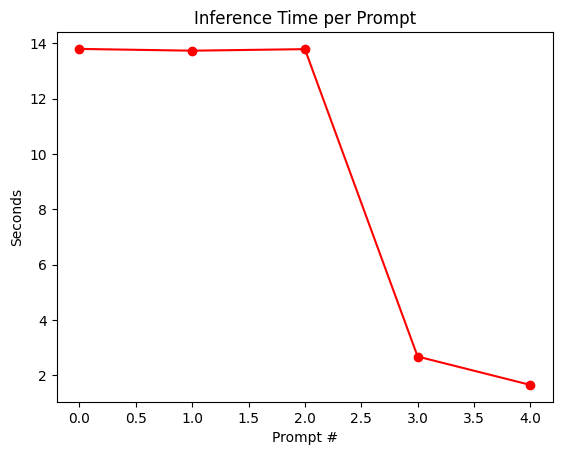

In [23]:
import time

times = []
prompts = [
    "What amenities do you provide?",
    "Do you have free breakfast?",
    "Can I bring pets?",
    "Is your hotel near downtown?",
    "What is the check-out time?"
]

for p in prompts:
    start = time.time()
    _ = generate_response(p)
    times.append(time.time() - start)

plt.plot(times, marker='o', color='red')
plt.title("Inference Time per Prompt")
plt.xlabel("Prompt #")
plt.ylabel("Seconds")
plt.show()


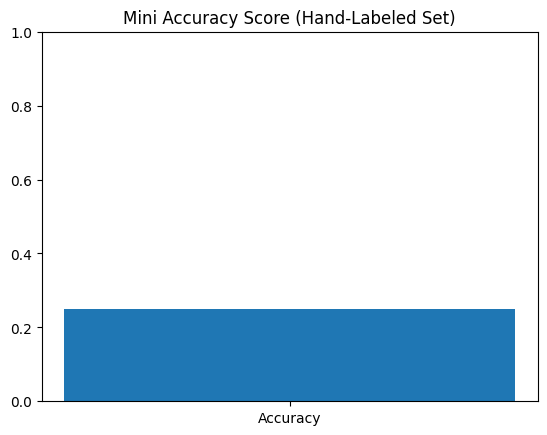

In [25]:
import matplotlib.pyplot as plt

eval_set = [
    ("Do you offer breakfast?", "yes"),
    ("Do you have a pool?", "yes"),
    ("Is parking free?", "yes"),
    ("Do you allow pets?", "no"),
]

correct = 0
for q, expected in eval_set:
    ans = generate_response(q).lower()
    if expected in ans:
        correct += 1

accuracy = correct / len(eval_set)

plt.bar(["Accuracy"], [accuracy])
plt.ylim(0,1)
plt.title("Mini Accuracy Score (Hand-Labeled Set)")
plt.show()


In [26]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

# Paths
base_model_name = "microsoft/Phi-3-mini-4k-instruct"
lora_path = "/content/drive/MyDrive/PHI3_FINETUNE/lora"
save_path = "/content/drive/MyDrive/PHI3_FINETUNE/merged_model"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Load base model in FP16
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Load LoRA
lora_model = PeftModel.from_pretrained(
    base_model,
    lora_path,
    torch_dtype=torch.float16,
)

# Merge LoRA → full model
merged_model = lora_model.merge_and_unload()
print("LoRA successfully merged into full model!")

# Save merged model
merged_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Full model saved at:", save_path)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LoRA successfully merged into full model!
Full model saved at: /content/drive/MyDrive/PHI3_FINETUNE/merged_model


In [ ]:
!huggingface-cli login
